# Welcome to ONSSET

This is the full code for the Open Source Spatial Electrification Toolkit. This page will guide you through the code, as well as the various parameters that can be set to explore any scenario of interest. The code is split up into blocks, and each one has a preceding block of text to explain it.

### Here you can choose the country of the analysis, as well as the modelling period.

In [17]:
country = 'Ghana'

# Available options:
# Botswana
# Ethiopia
# Ghana
# Ivory Coast
# Kenya
# Mozambique
# Nigeria
# Somalia
# Tanzania
# Zambia

START_YEAR = 2015
END_YEAR = 2030

%matplotlib inline
from extra_funcs import *

# Step 1 and 2. GIS data collection and processing

GIS data collection and processing is a demanding and time consuming process. The necessary layers should be prepared and calibarated properly for the model to work. In this case pre-made data will be used in a form of .csv files avaialble <a href="https://drive.google.com/drive/folders/0B4H9lfvb9fHKUFNUUHM5UTJ6WW8" target="_blank">here</a>.

You can see an example for the selected country below.

In [18]:
df = pd.read_csv('{}.csv'.format(country))
display(Markdown('### A random sampling from the input file for {}'.format(country)))
df[['Country','X','Y','Pop','GridDistPlan','NightLights','TravelHours','GHI',
    'WindVel','Hydropower','HydropowerDist']].sample(7)

### A random sampling from the input file for Ghana

,Country,X,Y,Pop,GridDistPlan,NightLights,TravelHours,GHI,WindVel,Hydropower,HydropowerDist
1611,Ghana,-67.013580,772.623901,3011.519775,43.418694,0,1.0,2084,0.0,146.028000,26.422405
1675,Ghana,-267.013580,752.623901,11974.721680,16.730562,0,2.0,2032,0.0,150.585999,49.577705
1306,Ghana,-297.013580,842.623901,2896.544922,19.908764,0,5.0,2049,0.0,737.221985,29.680172
2264,Ghana,-107.013580,622.623901,15098.732420,0.089681,0,2.0,2014,0.0,243.878998,16.514616
1088,Ghana,-197.013580,902.623901,279.910034,8.394205,0,6.0,2093,0.0,914.239014,31.473675
2331,Ghana,-297.013580,592.623901,3744.816650,4.161351,0,4.0,1979,0.0,139.542007,4.071473
1333,Ghana,-27.013582,842.623901,576.741150,50.709797,0,3.0,2093,0.0,272.058990,43.413326


# Step 3a. Enter country specific data (Social)

These are values that vary per country. They should be changed accordingly to better reflect the selected country's current and expected development.

In [19]:
pop_2015 = 46000000
pop_2030 = 65411000

urban_ratio_2015 = 0.19472
urban_ratio_2030 = 0.26808

num_people_per_hh = 5

# Step 3b. Enter country specific data (Energy Access Target)

In [20]:
scenario = 900  #  in kWh/household/year (examples are 22, 224, 695, 1800, 2195)

df = condition(df)
df = grid_penalties(df)
df = wind(df)
df = pop(df, pop_2015, urban_ratio_2015, pop_2030, urban_ratio_2030)

# Step 3c. Enter country specific data (Preparation - Calibration)
The cell below contains the procedures to prepare the geospatial data and make it ready to process a scenario. This includes setting grid penalties, calculating wind capacity factors and estimating current population and electricity access a values.

The most important part is to set the actual electricity access rate, and then to adjust the other parameters to let the software which settlements are electrified and which not.

In [21]:
elec_actual = 0.23

Then you should set the parameters that decide whether or not a settlement is grid-connected, and run the block to see what the result is.

### This will need to be repeated until a satisfactory value is reached!

In [22]:
# Set the minimum night light intensity, below which it is assumed there is no electricity access.
min_night_lights = 8

# In addition to the above, one of the below conditions must be reached to consider a settlement eelctrified.
pop_cutoff = 50000
max_grid_dist = 10  # in km
max_road_dist = 4  # in km

df[SET_ELEC_CURRENT] = df.apply(lambda row: 1
                                if row[SET_NIGHT_LIGHTS] > min_night_lights and
                                    (row[SET_POP_CALIB] > pop_cutoff or
                                    row[SET_GRID_DIST_CURRENT] < max_grid_dist or
                                    row[SET_ROAD_DIST] < max_road_dist) else 0, axis=1)

df.loc[df[SET_ELEC_CURRENT] == 1, SET_NEW_CONNECTIONS] = df[SET_POP_FUTURE] - df[SET_POP_CALIB]
df.loc[df[SET_ELEC_CURRENT] == 0, SET_NEW_CONNECTIONS] = df[SET_POP_FUTURE]
df.loc[df[SET_NEW_CONNECTIONS] < 0, SET_NEW_CONNECTIONS] = 0

elec_modelled = df.loc[df[SET_ELEC_CURRENT] == 1, SET_POP_CALIB].sum() / pop_2015
display(Markdown('### The modelled electrification rate is {:.2f}, compared to the actual value of {:.2f}. \
                 If this is acceptable, you can continue.'.format(elec_modelled, elec_actual)))
display(Markdown('### A random sampling from the input file for {}, showing some newly calculated columns'
                 .format(country)))
df[['X_deg','Y_deg','Pop2030','IsUrban','Elec2015','WindCF',SET_GRID_PENALTY]].sample(5)

### The modelled electrification rate is 0.35, compared to the actual value of 0.23.                  If this is acceptable, you can continue.

### A random sampling from the input file for Ghana, showing some newly calculated columns

,X_deg,Y_deg,Pop2030,IsUrban,Elec2015,WindCF,GridPenalty
1043,0.655648,8.314204,7656.891920,0,0,0.077431,1.02
204,-2.488455,10.366198,19448.102173,0,0,0.000000,1.05
1631,-2.578287,6.880122,19933.544072,0,0,0.000000,1.05
873,-2.129129,8.671932,286.578682,0,0,0.077431,1.05
1537,0.206491,7.149375,62.904282,0,0,0.000000,1.02


# Step 3d. Enter country specific data (Technology specifications & costs)

The cell below contains all the information that is used to calculate the levelised costs for all the technologies, including grid. These should be updated to reflect the most accurate values.

The following values can be provided by KTH dESA, based on OSeMOSYS, the open source optimization model for long-run integrated assessment and energy planning.

In [23]:
grid_price = 0.063007372 # This is the grid cost electricity USD/kWh as expected in the years of the analysis
grid_capacity_investment_cost = 1791.308066  # The cost in USD/kW to for capacity upgrades of the grid
grid_losses = 0.193875  # The fraction of electricity lost in transmission and distribution
base_to_peak = 0.529580937 # The ratio from peak grid demand to base demand

This is the diesel price USD/liter as expected in the years of the analysis

In [24]:
diesel_price = 0.345

These are the capital costs in USD/kW for each different technology.

In [25]:
sa_diesel_capital_cost = 938
sa_pv_capital_cost = 5500
mg_diesel_capital_cost = 721
mg_pv_capital_cost = 4300
mg_wind_capital_cost = 3000
mg_hydro_capital_cost = 5000

# Step 4. Estimating the LCoE per technology under various demand profiles

Every technology yields a different Levelized Cost for electricity production (LCoE) based on specific characteristics such as the population size and resource availability and/or cost. To illustrate, the cost of providing electricity in a low populated, isolated location (far from grid and roads) will probably be a more demanding (thus expensive) task than a high populated urban settlement. 

Here is an example of how the different technologies perform under the followinga assumptions:
 - Distance from the National Electricity grid: 20 km
 - Global Horizontal Irradiation: 1500 kWh/m2/year
 - Hydro Availability: Positive
 - Diesel price: 0.345 USD/liter
 
 ### Note: this block takes a bit of time

In [26]:
project_life = END_YEAR - START_YEAR
grid_lcoes = get_grid_lcoe_table(scenario, max_grid_extension_dist, num_people_per_hh, grid_losses, base_to_peak,
                        grid_price, grid_capacity_investment_cost, project_life)
display(Markdown('### Example of LCoE variation (in USD/kWh) per technology depending on number of people residing a settlement'))

lcoe_eg_people = [10, 500, 1000, 2000, 5000, 10000]
lcoe_eg_people_display = ['{} people'.format(p) for p in lcoe_eg_people]
lcoe_sample = pd.DataFrame(columns=['grid', 'sa_diesel','sa_pv','mg_diesel','mg_pv','mg_wind','mg_hydro'],
                           index=lcoe_eg_people_display)

lcoe_sample['grid'] = [get_grid_lcoe(p, scenario, num_people_per_hh, False, grid_losses,
                   base_to_peak, grid_price, grid_capacity_investment_cost, 20, project_life) for p in lcoe_eg_people]
lcoe_sample['mg_wind'] = [get_mg_wind_lcoe(p, scenario, num_people_per_hh, False, 0.4,
                                           mg_wind_capital_cost, project_life) for p in lcoe_eg_people]
lcoe_sample['mg_hydro'] = [get_mg_hydro_lcoe(p, scenario, num_people_per_hh, False, 0.4,
                                             mg_hydro_capital_cost, project_life) for p in lcoe_eg_people]
lcoe_sample['mg_pv'] = [get_mg_pv_lcoe(p, scenario, num_people_per_hh, False, 1500,
                                       mg_pv_capital_cost, project_life) for p in lcoe_eg_people]
lcoe_sample['mg_diesel'] = [get_mg_diesel_lcoe(p, scenario, num_people_per_hh, False, 0.345,
                                               mg_diesel_capital_cost, project_life) for p in lcoe_eg_people]
lcoe_sample['sa_pv'] = [get_sa_pv_lcoe(p, scenario, num_people_per_hh, False, 1500,
                                       sa_pv_capital_cost, project_life) for p in lcoe_eg_people]
lcoe_sample['sa_diesel'] = [get_sa_diesel_lcoe(p, scenario, num_people_per_hh, False, 0.345,
                                               sa_diesel_capital_cost, project_life) for p in lcoe_eg_people]
lcoe_sample.head(10)

### Example of LCoE variation (in USD/kWh) per technology depending on number of people residing a settlement

,grid,sa_diesel,sa_pv,mg_diesel,mg_pv,mg_wind,mg_hydro
10 people,22.343413,0.202476,0.543061,4.174740,4.144666,3.892932,3.855849
500 people,1.183240,0.202476,0.543061,0.739085,0.943454,0.691720,0.645202
1000 people,0.763193,0.202476,0.543061,0.573335,0.789014,0.537280,0.499585
2000 people,0.502091,0.202476,0.543061,0.456132,0.679809,0.428075,0.397133
5000 people,0.333594,0.202476,0.543061,0.352134,0.582908,0.331174,0.306582
10000 people,0.257903,0.202476,0.543061,0.299719,0.534070,0.282335,0.261071


# Step 5. Calculate technology costs for every settlement in the country

Based on the previous calculation this piece of code identifies the LCoE that every technology can provide, for each single populated settlement of the selected country.

In [27]:
df = techs_only(df, diesel_price, scenario, num_people_per_hh, mg_hydro_capital_cost,
                mg_pv_capital_cost, mg_wind_capital_cost, mg_diesel_capital_cost,
                sa_diesel_capital_cost, sa_pv_capital_cost, END_YEAR - START_YEAR)
display(Markdown('### A selection of LCoEs achieved for a sample of settlements'))
df[[SET_LCOE_MG_HYDRO, SET_LCOE_MG_PV, SET_LCOE_SA_PV, SET_LCOE_MG_DIESEL, SET_LCOE_SA_DIESEL,
    SET_LCOE_MG_WIND]].sample(7)

### A selection of LCoEs achieved for a sample of settlements

,mg_hydro,mg_pv,sa_pv,mg_diesel,sa_diesel,mg_wind
128,99.0,0.474605,0.375042,0.369654,0.338910,99.0
505,99.0,0.418169,0.379586,0.306521,0.360496,99.0
47,99.0,0.442338,0.370606,0.339581,0.360496,99.0
956,99.0,0.407484,0.385880,0.291102,0.382083,99.0
793,99.0,0.364227,0.385880,0.244157,0.371290,99.0
228,99.0,0.411001,0.375042,0.302950,0.371290,99.0
841,99.0,99.000000,0.387532,1.717870,0.360496,99.0


# Step 6. Grid extensions - The electrification algorithm
This cell takes all the currently grid-connected points in the country, and looks at the points within a certain distance from them, to see if it is more ecnomical to connect them to the grid, or to use one of the non-grid technologies calculate above. Once more points are connected to the grid, the process is repeated, so that new points close to those points might also be connected. This is repeated until there are no new points to connect to the grid.

The onle value that needs to be entered is the additional cost paid when extending the grid, to strengthen the previous sections of grid. It is given asa ratio of the original cost of that grid section

In [28]:
existing_grid_cost_ratio = 0.1

Then this code runs the analysis.

In [29]:
df = run_elec(df, grid_lcoes, grid_price, existing_grid_cost_ratio, max_grid_extension_dist)
elec2015 = df['Elec2015'].sum()
elec2030 = df.loc[df[SET_LCOE_GRID] < 99, SET_LCOE_GRID].count()
display(Markdown('### The algorithm found {} new settlements to connect to the grid'.format(elec2030 - elec2015)))

Electrification loop 1 with 637 electrified
Electrification loop 2 with 812 electrified
Electrification loop 3 with 68 electrified
Electrification loop 4 with 1 electrified


### The algorithm found 1449 new settlements to connect to the grid

# Step 7 - Results, Summaries and Visualization
With all the calculations and grid-extensions complete, this cell gets the final results on which technology was chosen for each point, how much capacity needs to be installed and what it will cost. Then the summaries are generated, to show the overall requirements for the country. The only values that can be changed here are some capacity factor values for different technologies.

In [30]:
df = results_columns(df, scenario, base_to_peak, num_people_per_hh, diesel_price, grid_price,
                grid_losses, grid_capacity_investment_cost, project_life)

rows = []
techs = [SET_LCOE_GRID,SET_LCOE_SA_DIESEL,SET_LCOE_SA_PV,SET_LCOE_MG_DIESEL,
         SET_LCOE_MG_PV,SET_LCOE_MG_WIND,SET_LCOE_MG_HYDRO]
colors = ['#3f3f3f','#55f76b','#fb9580','#038214','#9e351f','#810083','#001ce8']
techs_colors = dict(zip(techs, colors))

rows.extend([SUM_POPULATION_PREFIX + t for t in techs])
rows.extend([SUM_NEW_CONNECTIONS_PREFIX + t for t in techs])
rows.extend([SUM_CAPACITY_PREFIX + t for t in techs])
rows.extend([SUM_INVESTMENT_PREFIX + t for t in techs])
summary = pd.Series(index=rows, name=country)

for t in techs:
    summary.loc[SUM_POPULATION_PREFIX + t] = df.loc[df[SET_MINIMUM_OVERALL] == t, SET_POP_FUTURE].sum()
    summary.loc[SUM_NEW_CONNECTIONS_PREFIX + t] = df.loc[df[SET_MINIMUM_OVERALL] == t, SET_NEW_CONNECTIONS].sum()
    summary.loc[SUM_CAPACITY_PREFIX + t] = df.loc[df[SET_MINIMUM_OVERALL] == t, SET_NEW_CAPACITY].sum()
    summary.loc[SUM_INVESTMENT_PREFIX + t] = df.loc[df[SET_MINIMUM_OVERALL] == t, SET_INVESTMENT_COST].sum()

display(Markdown('### Summaries  \nThese are the summaized results for full electrification of the selected country by 2030'))
index = techs + ['Total']
columns = ['Population', 'New connections', 'Capacity (kW)', 'Investments (million USD)']
summary_table = pd.DataFrame(index=index, columns=columns)

summary_table[columns[0]] = summary.iloc[0:7].astype(int).tolist() + [int(summary.iloc[0:7].sum())]
summary_table[columns[1]] = summary.iloc[7:14].astype(int).tolist() + [int(summary.iloc[7:14].sum())]
summary_table[columns[2]] = summary.iloc[14:21].astype(int).tolist() + [int(summary.iloc[14:21].sum())]
summary_table[columns[3]] = [round(x/1e4)/1e2 for x in summary.iloc[21:28].astype(float).tolist()] + [round(summary.iloc[21:28].sum()/1e4)/1e2]
summary_table.head(10)

### Summaries  
These are the summaized results for full electrification of the selected country by 2030

,Population,New connections,Capacity (kW),Investments (million USD)
grid,62691887,46410660,1800751,12011.42
sa_diesel,698037,698037,40980,56.25
sa_pv,284795,284795,26896,147.93
mg_diesel,2578671,2578671,151389,485.21
mg_pv,0,0,0,0.00
mg_wind,0,0,0,0.00
mg_hydro,146342,146342,6014,58.49
Total,66399735,50118508,2026032,12759.30


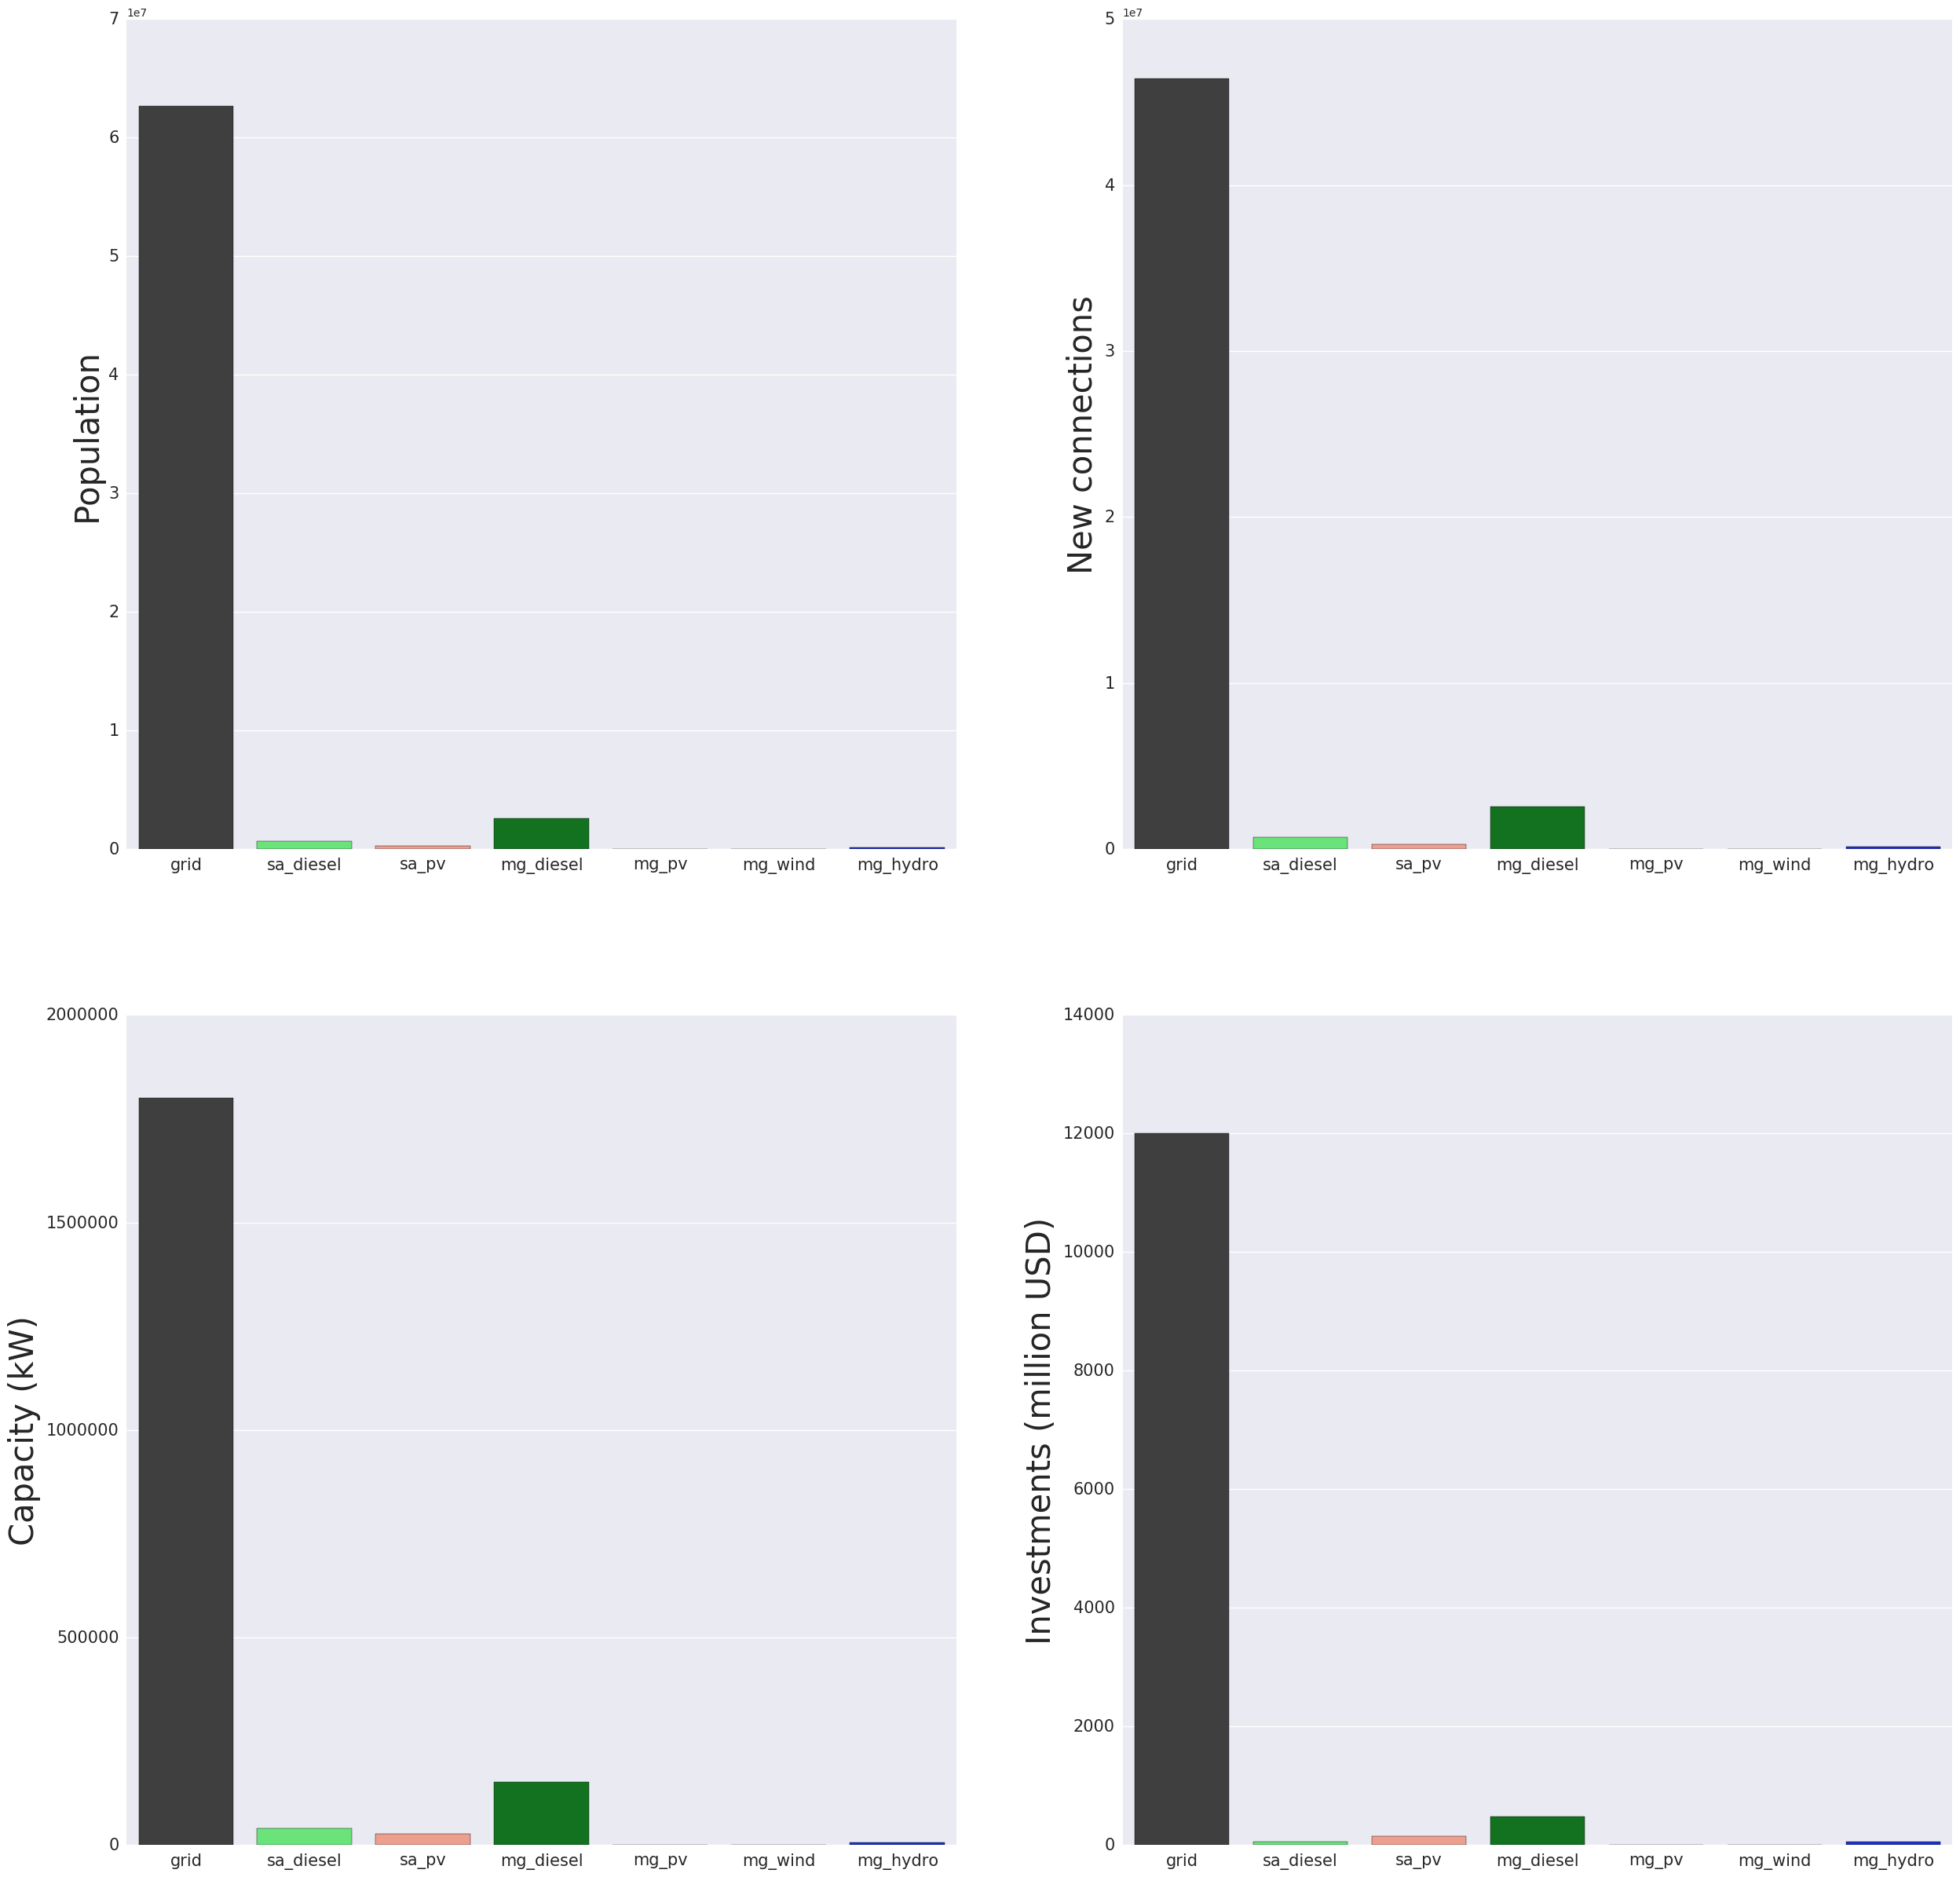

In [31]:
summary_plot=summary_table.drop(labels='Total',axis=0)
fig_size = [30, 30]
font_size = 15
plt.rcParams["figure.figsize"] = fig_size
f, axarr = plt.subplots(2, 2)
fig_size = [30, 30]
font_size = 15
plt.rcParams["figure.figsize"] = fig_size

sns.barplot(x=summary_plot.index.tolist(), y=columns[0], data=summary_plot, ax=axarr[0, 0], palette=colors)
axarr[0, 0].set_ylabel(columns[0], fontsize=2*font_size)
axarr[0, 0].tick_params(labelsize=font_size)
sns.barplot(x=summary_plot.index.tolist(), y=columns[1], data=summary_plot, ax=axarr[0, 1], palette=colors)
axarr[0, 1].set_ylabel(columns[1], fontsize=2*font_size)
axarr[0, 1].tick_params(labelsize=font_size)
sns.barplot(x=summary_plot.index.tolist(), y=columns[2], data=summary_plot, ax=axarr[1, 0], palette=colors)
axarr[1, 0].set_ylabel(columns[2], fontsize=2*font_size)
axarr[1, 0].tick_params(labelsize=font_size)
sns.barplot(x=summary_plot.index.tolist(), y=columns[3], data=summary_plot, ax=axarr[1, 1], palette=colors)
axarr[1, 1].set_ylabel(columns[3], fontsize=2*font_size)
axarr[1, 1].tick_params(labelsize=font_size)

## Mapping of electrification results

This code generates two maps:
 - one showing the spread of technologies
 - one showing the cost of electricity at each point
 
They can be accessed using the links below.

In [32]:
x_ave = df[SET_X_DEG].mean()
y_ave = df[SET_Y_DEG].mean()
lcoe_ave = df[SET_MINIMUM_OVERALL_LCOE].median()

map_tech = folium.Map(location=[y_ave,x_ave], zoom_start=6)
for index, row in df.iterrows():
    tech_color = techs_colors[(row[SET_MINIMUM_OVERALL])]
    folium.CircleMarker([row[SET_Y_DEG], row[SET_X_DEG]],
                        radius=5000,#cell_size*300*(row['LCOE']/lcoe_ave)**2,
                        #popup='LCOE: {0:.3f} USD/kWh'.format(row['LCOE']),
                        color=tech_color,
                        fill_color=tech_color,
                       ).add_to(map_tech)

map_tech_output = 'maps/map_{}{}_tech.html'.format(country, scenario)
map_tech.save(map_tech_output)

lcoe_colors = {0.1: '#edf8fb',0.2: '#ccece6',0.3: '#99d8c9',0.4: '#66c2a4',0.5: '#2ca25f',0.6: '#006d2c'}
map_lcoe = folium.Map(location=[y_ave,x_ave], zoom_start=6)
for index, row in df.iterrows():
    lcoe = row[SET_MINIMUM_OVERALL_LCOE]
    if lcoe > 0.6: lcoe = 0.6
    lcoe_color = lcoe_colors[ceil(lcoe*10)/10]
    folium.CircleMarker([row[SET_Y_DEG], row[SET_X_DEG]],
                        radius=5000,#cell_size*300*(row['LCOE']/lcoe_ave)**2,
                        #popup='LCOE: {0:.3f} USD/kWh'.format(row['LCOE']),
                        color=lcoe_color,
                        fill_color=lcoe_color,
                       ).add_to(map_lcoe)

map_lcoe_output = 'maps/map_{}{}_lcoe.html'.format(country, scenario)
map_lcoe.save(map_lcoe_output)

display(Markdown('<a href="{}" target="_blank">Map of technology split</a>'.format(map_tech_output)))
display(Markdown('Colour coding for technology split:'))
display(HTML('<font color="{}">&bull;Grid</font>&nbsp;&nbsp;&nbsp;<font color="{}">&bull;SA Diesel</font>&nbsp;&nbsp;&nbsp;\
             <font color="{}">&bull;SA PV</font>&nbsp;&nbsp;&nbsp;<font color="{}">&bull;MG Diesel</font>&nbsp;&nbsp;&nbsp;\
             <font color="{}">&bull;MG PV</font>&nbsp;&nbsp;&nbsp;<font color="{}">&bull;Wind</font>&nbsp;&nbsp;&nbsp;\
             <font color="{}">&bull;Hydro</font>'.format(techs_colors[SET_LCOE_GRID], techs_colors[SET_LCOE_SA_DIESEL],
                                                         techs_colors[SET_LCOE_SA_PV], techs_colors[SET_LCOE_MG_DIESEL],
                                                         techs_colors[SET_LCOE_MG_PV], techs_colors[SET_LCOE_MG_WIND],
                                                         techs_colors[SET_LCOE_MG_HYDRO])))

display(Markdown('<a href="{}" target="_blank">Map of electricity cost</a>'.format(map_lcoe_output)))
display(Markdown('Colour coding for LCOE, in USD/kWh'))
cm.LinearColormap(['#edf8fb','#ccece6','#99d8c9','#66c2a4','#2ca25f','#006d2c'],
                  index=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6], vmin=0, vmax=0.6)

<a href="maps/map_Ghana900_tech.html" target="_blank">Map of technology split</a>

Colour coding for technology split:

<a href="maps/map_Ghana900_lcoe.html" target="_blank">Map of electricity cost</a>

Colour coding for LCOE, in USD/kWh